#### This code was written and executed in Google Colab and the datasets are stored in Google Drive

## Import Libraries

In [1]:
## File/Folder Management
import os
import shutil
import pathlib

## Data Manipulation
import pandas as pd
import numpy as np

## Computer Vision
import cv2
import matplotlib.pyplot as plt

# Tensorflow 
import tensorflow as tf
from tensorflow.keras.layers import Layer,Input,Dense,Flatten,Conv2D,MaxPool2D
from tensorflow.keras.models import Model

#### Delete previously generated data to avoid issues

In [2]:
!rm -r /content/Dutch_Training_2011 /content/NISDCC-offline-all-001-051-6g /content/signatures

rm: cannot remove '/content/Dutch_Training_2011': No such file or directory
rm: cannot remove '/content/NISDCC-offline-all-001-051-6g': No such file or directory
rm: cannot remove '/content/signatures': No such file or directory


#### Functions for Image Preprocessing

In [54]:
INPUT_SHAPE=(100,200)
def preprocess_image(image_path:str):
  """
  Preprocess Image

  Parameters
  -----------
  image_path : Image Path (str)
  """
  # Read in image from file path
  byte_img = tf.io.read_file(image_path)
  # Load in the image 
  img = tf.io.decode_jpeg(byte_img,1)
  
  # Preprocessing steps - resizing the image to be 100x100x3
  img = tf.image.resize(img, INPUT_SHAPE)
  # Scale image to be between 0 and 1 
  img = img / 255.0
  
  # Return image
  return img


In [55]:
# x=preprocess_image('/content/NISDCC-offline-all-001-051-6g/NISDCC-001_001_001_6g.PNG').numpy()
# plt.imshow(x[:,:,0],cmap='binary')


In [56]:
def preprocess_tuple(anchor_path,val_path,label):
  print(type(anchor_path))
  """
  Preprocess Tuple

  Parameters
  -----------
  anchor_path : Anchor Image Path (str)
  val_path : Validation Image Path (str)
  label : Label (int) 0 or 1
  """
  # print(tf.strings.as_string(anchor_path))
  return preprocess_image(anchor_path),preprocess_image(val_path),label

#### Overview of our DataFrame
The data dataframe has following columns
* anchor_images -- Reference signature.
* validation_images -- Signature which needs to be validated. It may be forged or original.
* labels -- 1 means anchor and validation signatures are same. 0 means the validation signature is forged.


In [57]:
anchor_images=[]
validation_images=[]
labels=[]  


### ICDAR 2009 Signature Verification Competition Dataset

In [58]:
folder_name='NISDCC-offline-all-001-051-6g'
!rm -r /content/NISDCC-offline-all-001-051-6g
!tar -xzf /content/drive/MyDrive/NISDCC-offline-all-001-051-6g.tgz -C /content/

##### Get all PNG images path

In [59]:
data_dir=pathlib.Path(f'/content/{folder_name}')
all_images=list(map(str,data_dir.glob('*.PNG')))

In [60]:
!rm -r /content/signatures
!mkdir /content/signatures

## Copying all genuine and forged images to appropriate path
for image_path in list(all_images):
  image_name=(image_path.split('/'))[-1]
  simulator=image_name[7:10]
  primary=image_name[11:14]
  count=image_name[15:18]

  if simulator==primary: ##Genuine
    if not os.path.exists(f'/content/signatures/{primary}'):
      os.mkdir(f'/content/signatures/{primary}')
    shutil.copyfile(image_path,f'/content/signatures/{primary}/{count}.PNG')

  else:## Forged
    if not os.path.exists(f'/content/signatures/{primary}_forg'):
      os.mkdir(f'/content/signatures/{primary}_forg')
    shutil.copyfile(image_path,f'/content/signatures/{primary}_forg/{simulator}_{count}.PNG')


In [61]:
for image_1 in range(len(all_images)):
  for image_2 in range(image_1,len(all_images)):
      image_name1=(all_images[image_1].split('/'))[-1]
      simulator1=image_name1[7:10]
      primary1=image_name1[11:14]
      count1=image_name1[15:18]

      image_name2=(all_images[image_2].split('/'))[-1]
      simulator2=image_name2[7:10]
      primary2=image_name2[11:14]
      count2=image_name2[15:18]

      if primary1==primary2: ##same sign origin
        if simulator1!=primary1 and simulator2!=primary1: ## Both images are forged
          continue
        elif simulator1==primary1 and simulator2==primary1: ## Both Signs Original 
          anchor_images+=[f'/content/signatures/{primary1}/{count1}.PNG']
          validation_images+=[f'/content/signatures/{primary2}/{count2}.PNG']
          labels+=[1]

          anchor_images+=[f'/content/signatures/{primary2}/{count2}.PNG']
          validation_images+=[f'/content/signatures/{primary1}/{count1}.PNG']
          labels+=[1]

        elif simulator1==primary1: ## First True
          anchor_images+=[f'/content/signatures/{primary1}/{count1}.PNG']
          validation_images+=[f'/content/signatures/{primary2}_forg/{simulator2}_{count2}.PNG']
          labels+=[0]
        elif simulator2==primary2: ## Second True
          anchor_images+=[f'/content/signatures/{primary2}/{count2}.PNG']
          validation_images+=[f'/content/signatures/{primary1}_forg/{simulator1}_{count1}.PNG']
          labels+=[0]

# ICDAR 2011 Signature Verification Competition

In [62]:
signs_2009=len(list(pathlib.Path('/content/signatures').glob('*')))//2
print(f"There are {signs_2009} unique signatures in 2009 dataset")

There are 12 unique signatures in 2009 dataset


In [63]:
!rm -r /content/Dutch_Training_2011
!unzip -q /content/drive/MyDrive/Dutch_Training_2011.zip -d /content/Dutch_Training_2011

In [64]:
forgeries_2011=pathlib.Path('/content/Dutch_Training_2011/Offline Forgeries').glob('*.png')
forgeries_2011=list(map(str,forgeries_2011))

genuine_2011=pathlib.Path('/content/Dutch_Training_2011/Offline Genuine').glob('*.PNG')
genuine_2011=list(map(str,genuine_2011))

In [65]:
## Copying all forged images to appropriate path
for image_path in list(forgeries_2011):
  image_name=(image_path.split('/'))[-1]
  forger_id=image_name[:4]
  primary=image_name[4:7]
  count=image_name[8:10]
  index=str(int(primary)+signs_2009)
  index='0'*(3-len(index))+str(index)

  if not os.path.exists(f'/content/signatures/{index}_forg'):
    os.mkdir(f'/content/signatures/{index}_forg')
  shutil.copyfile(image_path,f'/content/signatures/{index}_forg/{forger_id}_{count}.PNG')     

## Copying all genuine images to appropriate path
for image_path in list(genuine_2011):
  image_name=(image_path.split('/'))[-1]
  primary=image_name[:3]
  count=image_name[4:6]
  index=str(int(primary)+signs_2009)
  index='0'*(3-len(index))+str(index)

  if not os.path.exists(f'/content/signatures/{index}'):
    os.mkdir(f'/content/signatures/{index}')
  shutil.copyfile(image_path,f'/content/signatures/{index}/{count}.PNG')
       

In [66]:
## Pairing all Genuine Pairs as anchor and validation images (Cartesian Product ... kinda) 
for image_1 in range(len(genuine_2011)):
  for image_2 in range(image_1,len(genuine_2011)):
    image_name1=(genuine_2011[image_1].split('/'))[-1]
    primary1=image_name1[:3]
    count1=image_name1[4:6]
    index1=str(int(primary1)+signs_2009)
    index1='0'*(3-len(index1))+str(index1)

    image_name2=(genuine_2011[image_2].split('/'))[-1]
    primary2=image_name2[:3]
    count2=image_name2[4:6]
    index2=str(int(primary2)+signs_2009)
    index2='0'*(3-len(index2))+str(index2)

    if primary1==primary2:
      anchor_images+=[f'/content/signatures/{index1}/{count1}.PNG']
      validation_images+=[f'/content/signatures/{index2}/{count2}.PNG']
      labels+=[1]

      anchor_images+=[f'/content/signatures/{index2}/{count2}.PNG']
      validation_images+=[f'/content/signatures/{index1}/{count1}.PNG']
      labels+=[1]
    

## Pairing Genuine images with Forged
for genuine in range(len(genuine_2011)):
  for forged in range(len(forgeries_2011)):
    image_name1=(genuine_2011[genuine].split('/'))[-1]
    primary1=image_name1[:3]
    count1=image_name1[4:6]
    index1=str(int(primary1)+signs_2009)
    index1='0'*(3-len(index1))+str(index1)
    
    image_name2=(forgeries_2011[forged].split('/'))[-1]
    forger_id2=image_name2[:4]
    primary2=image_name2[4:7]
    count2=image_name2[8:10]
    index2=str(int(primary2)+signs_2009)
    index2='0'*(3-len(index2))+str(index2)

    if primary1==primary2:
      anchor_images+=[f'/content/signatures/{index1}/{count1}.PNG']
      validation_images+=[f'/content/signatures/{index2}_forg/{forger_id2}_{count2}.PNG']
      labels+=[0]

In [67]:
anchor_images=np.array(anchor_images)
validation_images=np.array(validation_images)
labels=np.array(labels)

In [68]:
df=pd.DataFrame(zip(anchor_images,validation_images,labels),columns=['anchor_images','validation_images','labels'])

In [69]:
df

,anchor_images,validation_images,labels
0,/content/signatures/009/005.PNG,/content/signatures/009_forg/037_003.PNG,0
1,/content/signatures/009/001.PNG,/content/signatures/009_forg/037_003.PNG,0
2,/content/signatures/009/002.PNG,/content/signatures/009_forg/037_003.PNG,0
3,/content/signatures/009/004.PNG,/content/signatures/009_forg/037_003.PNG,0
4,/content/signatures/009/003.PNG,/content/signatures/009_forg/037_003.PNG,0
...,...,...,...
17513,/content/signatures/027/15.PNG,/content/signatures/027_forg/0213_01.PNG,0
17514,/content/signatures/027/15.PNG,/content/signatures/027_forg/0213_04.PNG,0
17515,/content/signatures/027/15.PNG,/content/signatures/027_forg/0106_03.PNG,0
17516,/content/signatures/027/15.PNG,/content/signatures/027_forg/0210_04.PNG,0


In [70]:
df['labels'].value_counts()

0    11758
1     5760
Name: labels, dtype: int64

This is a highly imbalanced dataset. We will use Focal Loss to deal with imbalance.

In [71]:
data=tf.data.Dataset.from_tensor_slices((df['anchor_images'].values,df['validation_images'].values,df['labels'].values))

In [72]:
print(len(data))
data

17518


<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Mapping Preprocessing function to pipeline. 
### Extracting only a few (to avoid GPU bottleneck), shuffling, batching and prefetching the data pipeline 
### Splitting dataset to train and test set

In [73]:
data = data.map(preprocess_tuple)
data = data.shuffle(buffer_size=1024)
# data=data.take(6000)
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

<class 'tensorflow.python.framework.ops.Tensor'>


# Building Siamese Neural Network

# Make Embedding Layer

In [29]:
## Make Embedding Model 
def make_embedding():

  inp=Input(shape=(*INPUT_SHAPE,1),name='input_layer') ## Input Layer
  
  conv1=Conv2D(64,(10,10),activation='relu')(inp) 
  maxp1=MaxPool2D(64,(2,2),padding='same')(conv1)

  conv2=Conv2D(128,(7,7),activation='relu')(maxp1)
  maxp2=MaxPool2D(64,(2,2),padding='same')(conv2)

  conv3=Conv2D(128,(4,4),activation='relu')(maxp2)
  maxp3=MaxPool2D(64,(2,2),padding='same')(conv3)

  conv4=Conv2D(256,(4,4),activation='relu')(maxp3)
  flatten1=Flatten()(conv4)

  dense1 = Dense(4096,activation='sigmoid')(flatten1)
  model= Model(inputs=[inp],outputs=[dense1],name='embedding_model')
  print(model.summary())
  return model

In [30]:
embedding = make_embedding()

Model: "embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 191, 64)       6464      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 90, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 42, 128)   

# Build Siamese Distance Layer

In [31]:
## Siamese Distance class
class L1Dist(Layer):
  def __init__(self,**kwargs):
    super().__init__()
  
  def call(self,input_embedding,validation_embedding):
    return tf.math.abs(input_embedding-validation_embedding)

In [32]:
l1=L1Dist()

# Make Siamese Model

In [33]:
## Creating two input streams of anchor and positive/negative image
input_image = Input(name='input_img', shape=(*INPUT_SHAPE,1))
validation_image = Input(name='validation_img', shape=(*INPUT_SHAPE,1))

## Embedding the images
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [34]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [35]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 embedding_model (Functional)   (None, 4096)         114445120   ['input_img[0][0]',              
                                                                  'validation_img[0][

In [36]:
def make_siamese_model():
  input_image=Input(name='input_layer',shape=(*INPUT_SHAPE,1))
  
  validation_image=Input(name='val_layer',shape=(*INPUT_SHAPE,1))
  
  siamese_layer=L1Dist()
  siamese_layer._name='distance'
  distances=siamese_layer(embedding(input_image),embedding(validation_image))

  classifier=Dense(1,activation='sigmoid')(distances)

  return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwo')

In [37]:
siamese_model = make_siamese_model()

In [38]:
siamese_model.summary()

Model: "SiameseNetwo"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 100, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 val_layer (InputLayer)         [(None, 100, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 embedding_model (Functional)   (None, 4096)         114445120   ['input_layer[0][0]',            
                                                                  'val_layer[0][0]']   

#### Plotting the entire Siamese network

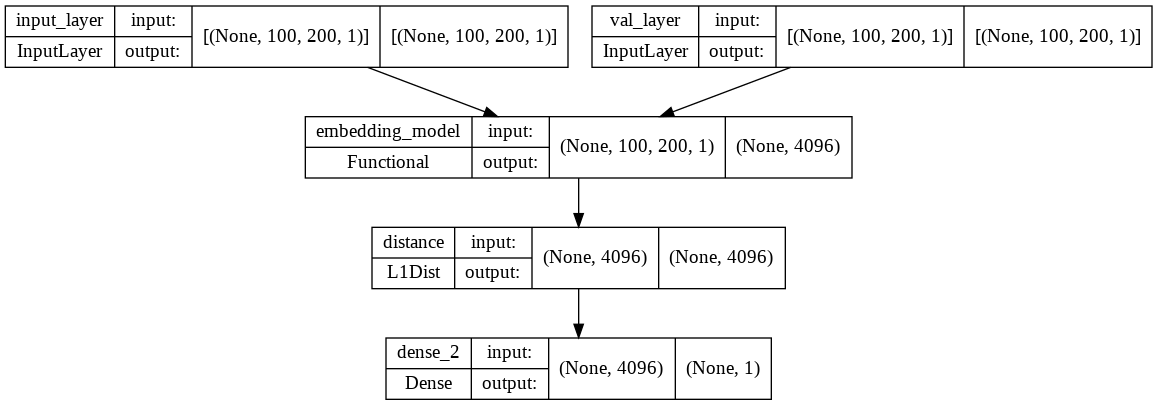

In [39]:
tf.keras.utils.plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train a Siamese Network

Loss Function and Optimizer

In [42]:
binary_focal_loss=tf.keras.losses.BinaryFocalCrossentropy()

optimizer=tf.optimizers.Adam(1e-4)

Checkpoints

In [43]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(optimizer=optimizer,siamese_model=siamese_model)

Train Step

In [44]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_focal_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

Train Loop

In [45]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        # print(len(data))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            # print('b',len(batch))
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [46]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)

In [ ]:
siamese_model.save('siamesemodelfocal.h5')

In [ ]:
siamese_model.save('/content/drive/MyDrive/siamesemodelfocal.h5')

In [47]:
siamese_model=tf.keras.models.load_model('/content/drive/MyDrive/siamesemodelfocal.h5',
                                         custom_objects={'L1Dist':L1Dist, 'BinaryFocalCrossentropy':tf.keras.losses.BinaryFocalCrossentropy})

In [48]:
siamese_model

## Model Evaluation

In [78]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [79]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [80]:
siamese_model=tf.keras.models.load_model('/content/drive/MyDrive/siamesemodelfocal.h5',
                                         custom_objects={'L1Dist':L1Dist, 'BinaryFocalCrossentropy':tf.keras.losses.BinaryFocalCrossentropy})
def evaluate(data):
    y_true=[]
    y_hat=[]
    # Loop through each batch
    for idx, batch in enumerate(data):
        # print('b',len(batch))
        # print(batch)
        y_true+=[i for i in batch[2]]
        y_hat += [1 if i>0.5 else 0 for i in siamese_model.predict([batch[0], batch[1]])]
        # print(y_true)
        # print(y_hat)
        # print('----')
    # Creating a metric object 
    precision = Precision()
    precision.update_state(y_true, y_hat)
    recall = Recall()
    recall.update_state(y_true, y_hat)

    return precision.result().numpy(),recall.result().numpy()
